In [1]:
import firebase_admin
from firebase_admin import credentials, db
import pandas as pd

# Initialize Firebase (only once)
cred = credentials.Certificate("remotedoc-a8b6d-firebase-adminsdk-fbsvc-390e2dcfaf.json")
try:
    firebase_admin.get_app()
except ValueError:
    firebase_admin.initialize_app(cred, {
        'databaseURL': 'https://remotedoc-a8b6d-default-rtdb.firebaseio.com/'
    })

# Fetch data
ref = db.reference("patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/logs")
data = ref.get()

# Convert to DataFrame
df = pd.DataFrame.from_dict(data, orient="index")
print(df.columns)
print(df.head())


Index(['heartRate', 'movement', 'movementRange', 'presence', 'respirationRate',
       'timeRecorded'],
      dtype='object')
                      heartRate  movement  movementRange  presence  \
2025-09-22T21:59:00Z          0         2             67         1   
2025-09-22T22:01:09Z          0         2              7         1   
2025-09-22T22:01:26Z          0         2              4         1   
2025-09-22T22:01:47Z          0         1              1         1   
2025-09-22T22:01:59Z          0         1              1         1   

                      respirationRate          timeRecorded  
2025-09-22T21:59:00Z                0  2025-09-22T21:59:00Z  
2025-09-22T22:01:09Z                0  2025-09-22T22:01:09Z  
2025-09-22T22:01:26Z                0  2025-09-22T22:01:26Z  
2025-09-22T22:01:47Z                0  2025-09-22T22:01:47Z  
2025-09-22T22:01:59Z                0  2025-09-22T22:01:59Z  


In [3]:
df.reset_index(inplace=True)
df.rename(columns={"index": "timestamp"}, inplace=True)


In [4]:
df["timestamp"] = pd.to_datetime(df["timestamp"])


In [5]:
#import time

#while True:
    #data = ref.get()
    #df = pd.DataFrame.from_dict(data, orient="index")
    #df.reset_index(inplace=True)
    #df.rename(columns={"index": "timestamp"}, inplace=True)
    #df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    #print(df.tail(5))  # show latest 5 rows
    #time.sleep(100)     # wait 10 seconds before fetching again


In [ ]:
# ---------------------- Firebase node selector ----------------------
def get_patient_refs(patient_id: str):
    """Easily switch to another patient's node."""
    base = f"patients/{patient_id}"
    return {
        "logs": db.reference(f"{base}/logs"),
        "alerts": db.reference(f"{base}/alerts"),
        "status": db.reference(f"{base}/status"),
    }

# 🔹 Choose the patient ID once here
PATIENT_ID = "ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3"  # change this anytime
refs = get_patient_refs(PATIENT_ID)

# assign to global references for rest of the code
LOGS_REF = refs["logs"]
ALERTS_REF = refs["alerts"]
STATUS_REF = refs["status"]


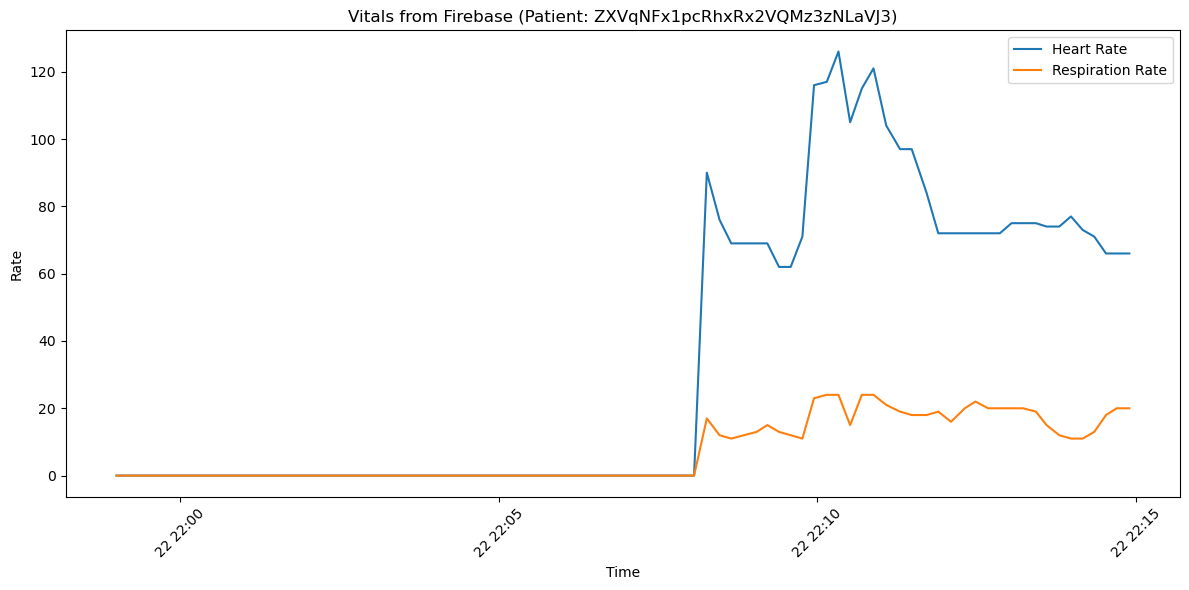

In [6]:
import matplotlib.pyplot as plt

# Use df instead of patient_df
plt.figure(figsize=(12,6))
plt.plot(df["timestamp"], df["heartRate"], label="Heart Rate")
plt.plot(df["timestamp"], df["respirationRate"], label="Respiration Rate")

plt.xlabel("Time")
plt.ylabel("Rate")
plt.title("Vitals from Firebase (Patient: ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3)")
plt.legend()
plt.xticks(rotation=45)   # rotate x-axis labels for readability
plt.tight_layout()
plt.show()


In [20]:
# Fetch data
ref = db.reference("patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/logs")
data = ref.get()

# Convert to DataFrame
df = pd.DataFrame.from_dict(data, orient="index")
print(df.columns)
print(df.head())


Index(['heartRate', 'movement', 'movementRange', 'presence', 'respirationRate',
       'timeRecorded'],
      dtype='object')
                      heartRate  movement  movementRange  presence  \
2025-09-22T21:59:00Z          0         2             67         1   
2025-09-22T22:01:09Z          0         2              7         1   
2025-09-22T22:01:26Z          0         2              4         1   
2025-09-22T22:01:47Z          0         1              1         1   
2025-09-22T22:01:59Z          0         1              1         1   

                      respirationRate          timeRecorded  
2025-09-22T21:59:00Z                0  2025-09-22T21:59:00Z  
2025-09-22T22:01:09Z                0  2025-09-22T22:01:09Z  
2025-09-22T22:01:26Z                0  2025-09-22T22:01:26Z  
2025-09-22T22:01:47Z                0  2025-09-22T22:01:47Z  
2025-09-22T22:01:59Z                0  2025-09-22T22:01:59Z  


In [2]:
# train_asthma_models.py
# Combined pipeline: feature engineering (vitals + dataset) -> RandomForest (tabular) + PyTorch LSTM fusion classifier
# Drops any RAG code. Saves models to disk: rf_model.pkl and fused_lstm.pt

import os
import math
import pickle
import time
import warnings
from typing import Tuple

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Firebase (for realtime vitals) - optional; if you don't want Firebase set AUTO_FETCH=False
AUTO_FETCH_FROM_FIREBASE = True
FIREBASE_CRED_PATH = "remotedoc-a8b6d-firebase-adminsdk-fbsvc-390e2dcfaf.json"
RTDB_PATH = "patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/logs"

ASDATA_CSV = "asthma_disease_data.csv"  # your training CSV (you asked to use this name)
RANDOM_STATE = 42
TIMESTEPS = 5   # sliding window size for LSTM
BATCH_SIZE = 32
LSTM_EMBED_DIM = 32
LSTM_HIDDEN = 64
EPOCHS = 30
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

# -------------------------
# 1. Helper feature-engineering functions (based on our earlier conversation)
# -------------------------
def map_movement_to_activity(movement):
    if pd.isna(movement):
        return np.nan
    movement = np.clip(movement, 0, 10)
    return round((movement / 10) * 10, 1)

def estimate_fev_fvc(df: pd.DataFrame) -> pd.DataFrame:
    """Estimate predicted_FEV1, predicted_FVC, predicted_fev1_fvc_ratio from vitals."""
    df = df.copy()
    # guard against constant columns
    for col in ["respirationRate", "heartRate", "movementRange"]:
        if df[col].max() == df[col].min():
            # add tiny jitter to avoid divide by zero
            df[col] = df[col].astype(float) + np.random.normal(0, 1e-6, size=len(df))
    df["resp_norm"] = (df["respirationRate"] - df["respirationRate"].min()) / (df["respirationRate"].max() - df["respirationRate"].min())
    df["hr_norm"]   = (df["heartRate"] - df["heartRate"].min()) / (df["heartRate"].max() - df["heartRate"].min())
    df["move_norm"] = (df["movementRange"] - df["movementRange"].min()) / (df["movementRange"].max() - df["movementRange"].min())

    df["predicted_FVC"] = 3.5 + 1.2 * df["move_norm"] + 0.8 * df["resp_norm"]
    df["predicted_FEV1"] = 2.5 + 0.7 * df["move_norm"] - 0.5 * (df["resp_norm"] - df["hr_norm"])
    df["predicted_fev1_fvc_ratio"] = (df["predicted_FEV1"] / df["predicted_FVC"]).clip(0.5, 1.0)
    return df

def detect_chest_tightness(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    ELEVATED_HR = 95
    ELEVATED_RESP = 22
    LOW_ACTIVITY = 1.5
    df["chest_tightness_score"] = np.where(
        (df["respirationRate"] > ELEVATED_RESP) &
        (df["heartRate"] > ELEVATED_HR) &
        (df["movementRange"] < LOW_ACTIVITY),
        1, 0
    )
    df["chest_tightness_index"] = (df["respirationRate"] * df["heartRate"]) / (df["movementRange"] + 0.1)
    return df

def detect_shortness_of_breath(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    HIGH_RESP_RATE = 24
    LOW_MOVEMENT = 1.5
    HIGH_HEART_RATE = 100
    df["shortness_of_breath_score"] = np.where(
        (df["respirationRate"] > HIGH_RESP_RATE) &
        (df["movementRange"] < LOW_MOVEMENT) &
        (df["heartRate"] > HIGH_HEART_RATE),
        1, 0
    )
    df["breath_stress_index"] = df["respirationRate"] / (df["movementRange"] + 0.1)
    return df

def detect_exercise_induced_stress(df: pd.DataFrame, window=5) -> pd.DataFrame:
    df = df.copy().reset_index(drop=True)
    df["hr_smooth"] = df["heartRate"].rolling(window, min_periods=1).mean()
    df["resp_smooth"] = df["respirationRate"].rolling(window, min_periods=1).mean()
    df["move_smooth"] = df["movementRange"].rolling(window, min_periods=1).mean()
    base_hr = df["hr_smooth"].quantile(0.25)
    base_resp = df["resp_smooth"].quantile(0.25)
    base_move = df["move_smooth"].quantile(0.25)
    df["exercise_phase"] = ((df["move_smooth"] > base_move * 1.5) & (df["hr_smooth"] > base_hr * 1.4)).astype(int)
    df["high_respiration"] = (df["resp_smooth"] > base_resp * 1.5).astype(int)
    # In case predicted_fev1_fvc_ratio missing, fill with neutral high value
    if "predicted_fev1_fvc_ratio" not in df.columns:
        df["predicted_fev1_fvc_ratio"] = 1.0
    df["low_fev_ratio"] = (df["predicted_fev1_fvc_ratio"] < 0.7).astype(int)
    df["exercise_induced_stress"] = 0
    for i in range(1, len(df)):
        if df.loc[i-1, "exercise_phase"] == 1 and (df.loc[i, "high_respiration"] == 1 or df.loc[i, "low_fev_ratio"] == 1):
            df.loc[i, "exercise_induced_stress"] = 1
    return df

# -------------------------
# 2. Fetch vitals from Firebase (optional) or read provided vitals CSV if preferred
# -------------------------
vitals_data = None
if AUTO_FETCH_FROM_FIREBASE:
    try:
        import firebase_admin
        from firebase_admin import credentials, db
        cred = credentials.Certificate(FIREBASE_CRED_PATH)
        try:
            firebase_admin.get_app()
        except ValueError:
            firebase_admin.initialize_app(cred, {'databaseURL': 'https://remotedoc-a8b6d-default-rtdb.firebaseio.com/'})
        ref = db.reference(RTDB_PATH)
        raw = ref.get()
        if not raw:
            warnings.warn(f"No data at RTDB path {RTDB_PATH}. Falling back to empty vitals dataframe.")
            vitals_data = pd.DataFrame()
        else:
            vitals_data = pd.DataFrame.from_dict(raw, orient="index")
            # normalize expected columns
            # rename if your column names differ; earlier raw had 'movement' and 'movementRange'
            if "movement" in vitals_data.columns and "movementRange" not in vitals_data.columns:
                vitals_data["movementRange"] = vitals_data["movement"]
            # ensure numeric columns exist
            for c in ["heartRate", "respirationRate", "movementRange"]:
                if c in vitals_data.columns:
                    vitals_data[c] = pd.to_numeric(vitals_data[c], errors="coerce")
            if "timeRecorded" in vitals_data.columns:
                vitals_data["timeRecorded"] = pd.to_datetime(vitals_data["timeRecorded"], errors="coerce")
            vitals_data = vitals_data.dropna(subset=["heartRate", "respirationRate", "movementRange"], how='all').reset_index(drop=True)
    except Exception as e:
        warnings.warn(f"Firebase fetch failed: {e}. Proceeding with empty vitals_data.")
        vitals_data = pd.DataFrame()

# If vitals_data empty, create a small default placeholder to allow merging (won't affect training labels)
if vitals_data is None or vitals_data.shape[0] == 0:
    print("No live vitals found; creating a small placeholder vitals dataframe (will be tiled to dataset).")
    vitals_data = pd.DataFrame({
        "heartRate": [70.0],
        "respirationRate": [16.0],
        "movementRange": [1.0]
    })

# -------------------------
# 3. Feature engineer vitals_data (same pipeline we iterated on)
# -------------------------
# Ensure numeric types
for c in ["heartRate", "respirationRate", "movementRange"]:
    vitals_data[c] = pd.to_numeric(vitals_data[c], errors="coerce").fillna(0.0)

# Add physical activity
vitals_data["PhysicalActivity"] = vitals_data["movementRange"].apply(map_movement_to_activity)

# Estimate FEV1/FVC etc
vitals_data = estimate_fev_fvc(vitals_data)

# chest tightness, shortness, exercise stress
vitals_data = detect_chest_tightness(vitals_data)
vitals_data = detect_shortness_of_breath(vitals_data)
vitals_data = detect_exercise_induced_stress(vitals_data)

# Keep only the columns we need to merge into the main dataset
vitals_keep_cols = [
    "heartRate", "respirationRate", "movementRange",
    "predicted_fev1_fvc_ratio", "shortness_of_breath_score",
    "chest_tightness_score", "exercise_induced_stress", "PhysicalActivity"
]
for c in vitals_keep_cols:
    if c not in vitals_data.columns:
        vitals_data[c] = 0.0

vitals_data = vitals_data[vitals_keep_cols].reset_index(drop=True)

print(f"\nProcessed vitals shape: {vitals_data.shape}")
print(vitals_data.head())

# -------------------------
# 4. Load asthma dataset (your CSV) and merge vitals into it
# -------------------------
if not os.path.exists(ASDATA_CSV):
    raise FileNotFoundError(f"Dataset CSV not found at {ASDATA_CSV}. Put your asthma_disease_data.csv file in working dir.")

asthma_df = pd.read_csv(ASDATA_CSV, sep=",")
print("\nLoaded asthma disease CSV: shape", asthma_df.shape)
print("Columns:", list(asthma_df.columns)[:50])

# Basic standardization of column names
# Some datasets used 'Diagnosis' or 'Diagnosis ' etc. We'll trim spaces.
asthma_df.columns = [c.strip() for c in asthma_df.columns]

# Map Diagnosis to numeric target (common value names in your CSV were 'Diagnosis' with strings or 0/1)
if "Diagnosis" in asthma_df.columns:
    # sometimes Diagnosis already numeric 0/1, sometimes 'Asthma'/'Normal'
    if asthma_df["Diagnosis"].dtype == object:
        asthma_df["Diagnosis"] = asthma_df["Diagnosis"].map({"Asthma": 1, "Normal": 0}).fillna(asthma_df["Diagnosis"])
    # try converting to numeric
    asthma_df["Diagnosis"] = pd.to_numeric(asthma_df["Diagnosis"], errors="coerce")
else:
    # if your file uses 'Diagnosis' under a different name, you'll need to adjust
    raise KeyError("Could not find 'Diagnosis' column in asthma CSV. Please ensure file contains Diagnosis column.")

# Drop rows that have no diagnosis
asthma_df = asthma_df.dropna(subset=["Diagnosis"]).reset_index(drop=True)

# Now merge vitals. We will tile/cycle vitals rows to match asthma_df length (safe if vitals are short)
n_rows = len(asthma_df)
n_vitals = len(vitals_data)
if n_vitals == 0:
    raise ValueError("No vitals rows to merge after processing.")

# replicate/cycle vitals to length of asthma dataset
indices = np.arange(n_rows) % n_vitals
vitals_expanded = vitals_data.iloc[indices].reset_index(drop=True)
vitals_expanded.index = asthma_df.index

# Merge by concatenation (add vitals columns to asthma dataset)
merged = pd.concat([asthma_df.reset_index(drop=True), vitals_expanded.reset_index(drop=True)], axis=1)
print("\nMerged dataset shape:", merged.shape)
print("Merged columns:", merged.columns.tolist())

# -------------------------
# 5. Prepare features + target for training
# -------------------------
# Features we use (as discussed)
features = [
    "heartRate", "respirationRate", "movementRange",
    "predicted_fev1_fvc_ratio", "shortness_of_breath_score",
    "chest_tightness_score", "exercise_induced_stress", "PhysicalActivity"
]

# Some of these may already exist in asthma_df — but after merge they should
missing_features = [f for f in features if f not in merged.columns]
if missing_features:
    raise KeyError(f"Missing required merged features: {missing_features}")

X_tabular = merged[features].astype(float).fillna(0.0)
y = merged["Diagnosis"].astype(int).values

print("\n--- Preparing features and target ---")
print("Shape of X:", X_tabular.shape)
print("Preview of X (first 5 rows):\n", X_tabular.head())
print("Preview of y (first 10):\n", y[:10])

# -------------------------
# 6. Train RandomForest classifier (tabular)
# -------------------------
print("\n--- TRAINING RANDOM FOREST (tabular features) ---")
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)

# split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_tabular, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y if len(np.unique(y))>1 else None
)

# Fit
rf.fit(X_train_rf, y_train_rf)
y_pred_rf = rf.predict(X_test_rf)
print("RF accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print(classification_report(y_test_rf, y_pred_rf))
print("Confusion matrix:\n", confusion_matrix(y_test_rf, y_pred_rf))

# Persist RF
with open("rf_tabular_model.pkl", "wb") as f:
    pickle.dump(rf, f)
print("Saved RandomForest to rf_tabular_model.pkl")

# We'll use RF predicted probability (positive class) as an extra feature for LSTM fusion.
rf_proba_all = rf.predict_proba(X_tabular)[:, 1]  # shape (n_samples,)

# -------------------------
# 7. Prepare sequences for LSTM (PyTorch)
#    - We'll create sliding windows of size TIMESTEPS
#    - Each sample's label is the Diagnosis at the last timestep
#    - We'll include rf_proba as an extra per-sample scalar feature (attached to the window's last row)
# -------------------------
print("\n--- Preparing sequences for LSTM ---")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tabular)  # shape (N, n_features)
n_samples, n_feats = X_scaled.shape

# Attach RF proba as extra column (same length)
X_with_rf = np.hstack([X_scaled, rf_proba_all.reshape(-1, 1)])  # shape (N, n_feats+1)

def create_sequences(X: np.ndarray, y: np.ndarray, timesteps: int):
    Xs, ys, rf_last = [], [], []
    for i in range(len(X) - timesteps + 1):
        seq = X[i:i+timesteps]
        label = y[i+timesteps-1]  # label at last timestep
        Xs.append(seq)
        ys.append(label)
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_with_rf, y, TIMESTEPS)
print("Sequences shape:", X_seq.shape, "Labels shape:", y_seq.shape)

# Shuffle & split for training
idx = np.arange(len(X_seq))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=RANDOM_STATE, stratify=y_seq if len(np.unique(y_seq))>1 else None)

X_train_seq = X_seq[train_idx]
X_test_seq = X_seq[test_idx]
y_train_seq = y_seq[train_idx]
y_test_seq = y_seq[test_idx]

print("Train sequences:", X_train_seq.shape, "Test sequences:", X_test_seq.shape)

# Convert to torch tensors
X_train_t = torch.tensor(X_train_seq, dtype=torch.float32).to(DEVICE)
y_train_t = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1).to(DEVICE)
X_test_t  = torch.tensor(X_test_seq, dtype=torch.float32).to(DEVICE)
y_test_t  = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(1).to(DEVICE)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# 8. Build PyTorch LSTM + fusion head
# -------------------------
class LSTM_FusionClassifier(nn.Module):
    def __init__(self, input_dim, lstm_hidden=64, lstm_layers=1, lstm_embed_dim=32, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, num_layers=lstm_layers, batch_first=True, bidirectional=False)
        self.fc_embed = nn.Linear(lstm_hidden, lstm_embed_dim)
        self.dropout = nn.Dropout(dropout)
        # after LSTM embed, we expect the rf_proba to be included already as one of the features (we can also re-add it)
        # We'll use embed + scalar RF-prob (we will also extract it from last timestep column)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_embed_dim + 1, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (batch, timesteps, features+rf)
        out, (h_n, c_n) = self.lstm(x)  # out: (batch, timesteps, hidden)
        # take last timestep hidden
        last_hidden = out[:, -1, :]  # (batch, hidden)
        embed = self.dropout(torch.relu(self.fc_embed(last_hidden)))  # (batch, lstm_embed_dim)
        # extract rf_proba from last timestep last column
        rf_proba_last = x[:, -1, -1].unsqueeze(1)  # (batch,1)
        fused = torch.cat([embed, rf_proba_last], dim=1)
        out = self.classifier(fused)
        return out

input_dim = X_with_rf.shape[1]  # features + rf_proba
model = LSTM_FusionClassifier(input_dim=input_dim, lstm_hidden=LSTM_HIDDEN, lstm_layers=1, lstm_embed_dim=LSTM_EMBED_DIM, dropout=0.2)
model = model.to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
crit = nn.BCELoss()

# -------------------------
# 9. Train PyTorch model
# -------------------------
print("\n--- TRAINING PyTorch LSTM + fusion classifier ---")
best_val_loss = float("inf")
patience = 5
patience_counter = 0
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    for xb, yb in train_loader:
        opt.zero_grad()
        preds = model(xb)
        loss = crit(preds, yb)
        loss.backward()
        opt.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0.0
    preds_list = []
    trues_list = []
    with torch.no_grad():
        for xb, yb in test_loader:
            out = model(xb)
            l = crit(out, yb)
            val_loss += l.item() * xb.size(0)
            preds_list.append(out.cpu().numpy())
            trues_list.append(yb.cpu().numpy())
    val_loss /= len(test_loader.dataset)
    preds_arr = np.vstack(preds_list) if preds_list else np.array([])
    trues_arr = np.vstack(trues_list) if trues_list else np.array([])

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "fused_lstm_best.pt")
        patience_counter = 0
    else:
        patience_counter += 1

    print(f"Epoch {epoch}/{EPOCHS} - train_loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f} - best_val_loss: {best_val_loss:.4f}")
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# load best weights
model.load_state_dict(torch.load("fused_lstm_best.pt", map_location=DEVICE))
print("Saved best fused LSTM to fused_lstm_best.pt")

# Final evaluation on test set
model.eval()
y_preds = []
y_true = []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb).cpu().numpy().flatten()
        y_preds.extend(out.tolist())
        y_true.extend(yb.cpu().numpy().flatten().tolist())

y_pred_labels = (np.array(y_preds) > 0.5).astype(int)
print("\n--- FINAL LSTM FUSION RESULTS ---")
if len(y_true) > 0 and len(np.unique(y_true)) > 1:
    print("Accuracy:", accuracy_score(y_true, y_pred_labels))
    print(classification_report(y_true, y_pred_labels))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred_labels))
else:
    print("Not enough positive/negative classes for meaningful classification metrics (check labels).")

# Save scaler and RF for later inference
with open("scaler_for_lstm.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("Saved scaler_for_lstm.pkl")

# Save final combined PyTorch model (state_dict already saved as fused_lstm_best.pt)
# Optionally save complete model architecture + state
torch.save({
    "model_state_dict": model.state_dict(),
    "input_dim": input_dim,
    "lstm_hidden": LSTM_HIDDEN,
    "lstm_embed_dim": LSTM_EMBED_DIM,
}, "fused_lstm_model.pt")
print("Saved fused_lstm_model.pt")

# -------------------------
# 10. Quick helper functions for inference
# -------------------------
def predict_on_new_vitals(vitals_df: pd.DataFrame, rf_model, pytorch_model, scaler_obj, timesteps=TIMESTEPS):
    """
    vitals_df: dataframe with same vitals features columns (heartRate, respirationRate, movementRange, PhysicalActivity, etc.)
    returns predicted probability for each sliding window's last timestep.
    """
    # feature-engineer
    v = vitals_df.copy()
    for c in ["heartRate", "respirationRate", "movementRange"]:
        v[c] = pd.to_numeric(v[c], errors="coerce").fillna(0.0)
    v["PhysicalActivity"] = v["movementRange"].apply(map_movement_to_activity)
    v = estimate_fev_fvc(v)
    v = detect_chest_tightness(v)
    v = detect_shortness_of_breath(v)
    v = detect_exercise_induced_stress(v)

    # ensure columns
    for c in features:
        if c not in v.columns:
            v[c] = 0.0

    X_local = v[features].astype(float).fillna(0.0)
    rf_p = rf_model.predict_proba(X_local)[:, 1]
    # scale X_local
    Xs = scaler_obj.transform(X_local)
    X_with_rf_local = np.hstack([Xs, rf_p.reshape(-1, 1)])
    # create windows
    if len(X_with_rf_local) < timesteps:
        # pad by repeating last row
        pad_count = timesteps - len(X_with_rf_local)
        pad_rows = np.repeat(X_with_rf_local[-1:], pad_count, axis=0)
        X_with_rf_local = np.vstack([pad_rows, X_with_rf_local])
    seqs = []
    for i in range(len(X_with_rf_local) - timesteps + 1):
        seqs.append(X_with_rf_local[i:i+timesteps])
    seqs = np.array(seqs)
    seqs_t = torch.tensor(seqs, dtype=torch.float32).to(DEVICE)
    pytorch_model.eval()
    out_probs = []
    with torch.no_grad():
        for i in range(0, len(seqs_t), BATCH_SIZE):
            batch = seqs_t[i:i+BATCH_SIZE]
            out = pytorch_model(batch).cpu().numpy().flatten()
            out_probs.extend(out.tolist())
    return out_probs

print("\nAll done. Models saved:")
print(" - rf_tabular_model.pkl")
print(" - fused_lstm_best.pt")
print(" - fused_lstm_model.pt")
print(" - scaler_for_lstm.pkl")

print("\nUsage notes:")
print(" - To infer on Firebase live vitals, fetch vitals rows, run `predict_on_new_vitals(...)` with loaded rf and pytorch model.")
print(" - This pipeline trains RF first and uses its predicted probability as an extra feature to the LSTM fusion model.")

# Example of loading models (commented):
# with open('rf_tabular_model.pkl','rb') as f: rf_loaded = pickle.load(f)
# map_model = LSTM_FusionClassifier(input_dim=input_dim, lstm_hidden=LSTM_HIDDEN, lstm_layers=1, lstm_embed_dim=LSTM_EMBED_DIM)
# map_model.load_state_dict(torch.load('fused_lstm_best.pt', map_location=DEVICE))
# map_model.to(DEVICE).eval()



Device: cpu

Processed vitals shape: (71, 8)
   heartRate  respirationRate  movementRange  predicted_fev1_fvc_ratio  \
0          0                0             67                  0.683933   
1          0                0              7                  0.710790   
2          0                0              4                  0.712514   
3          0                0              1                  0.714286   
4          0                0              1                  0.714286   

   shortness_of_breath_score  chest_tightness_score  exercise_induced_stress  \
0                          0                      0                        0   
1                          0                      0                        0   
2                          0                      0                        0   
3                          0                      0                        0   
4                          0                      0                        0   

   PhysicalActivity  
0      

In [37]:
import firebase_admin
from firebase_admin import credentials, db
import random
import time
from datetime import datetime, timezone

# ==========================
# 🔹 1. Initialize Firebase
# ==========================
cred = credentials.Certificate("remotedoc-a8b6d-firebase-adminsdk-fbsvc-390e2dcfaf.json")
try:
    firebase_admin.get_app()
except ValueError:
    firebase_admin.initialize_app(cred, {
        'databaseURL': 'https://remotedoc-a8b6d-default-rtdb.firebaseio.com/'
    })

# Reference to the logs section
ref = db.reference("/patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/logs/abnormalTest")

# ==========================
# 🔹 2. Generate Abnormal Data
# ==========================
def simulate_abnormal_vitals():
    """
    Simulate only abnormal vitals for:
    - Shortness of Breath (SoB)
    - Exercise-Induced Asthma (EIA)
    """
    # Randomly pick between two abnormal states
    mode = random.choice(["sob", "eia"])

    if mode == "sob":
        # Very high HR & RR, little or no movement
        heartRate = random.randint(120, 150)
        respirationRate = random.randint(30, 40)
        movement = random.randint(0, 1)
        print("🚨 Simulating Shortness of Breath episode...")
    else:  # EIA
        # HR rising but stabilizing, RR stays high, movement moderate
        heartRate = random.randint(100, 120)
        respirationRate = random.randint(28, 36)
        movement = random.randint(1, 3)
        print("⚠️ Simulating Exercise-Induced Asthma episode...")

    movementRange = random.randint(5, 80)
    presence = 1

    # Firebase-safe timestamp key
    timestamp = datetime.now(timezone.utc).isoformat().replace(":", "-").replace(".", "-")

    data = {
        "heartRate": heartRate,
        "respirationRate": respirationRate,
        "movement": movement,
        "movementRange": movementRange,
        "presence": presence,
        "timeRecorded": timestamp
    }

    ref.child(timestamp).set(data)
    print(f"📤 Sent → HR={heartRate}, RR={respirationRate}, MV={movement} ({mode})")


# ==========================
# 🔹 3. Push Repeated Abnormal Data
# ==========================
for i in range(10):  # push 10 abnormal samples
    simulate_abnormal_vitals()
    time.sleep(2)  # delay between readings

print("\n✅ Abnormal vitals successfully sent to Firebase for model testing.")


🚨 Simulating Shortness of Breath episode...
📤 Sent → HR=131, RR=38, MV=0 (sob)
🚨 Simulating Shortness of Breath episode...
📤 Sent → HR=142, RR=37, MV=1 (sob)
🚨 Simulating Shortness of Breath episode...
📤 Sent → HR=123, RR=30, MV=0 (sob)
🚨 Simulating Shortness of Breath episode...
📤 Sent → HR=140, RR=33, MV=1 (sob)
🚨 Simulating Shortness of Breath episode...
📤 Sent → HR=130, RR=37, MV=0 (sob)
⚠️ Simulating Exercise-Induced Asthma episode...
📤 Sent → HR=111, RR=30, MV=1 (eia)
🚨 Simulating Shortness of Breath episode...
📤 Sent → HR=146, RR=40, MV=0 (sob)
⚠️ Simulating Exercise-Induced Asthma episode...
📤 Sent → HR=114, RR=33, MV=2 (eia)
⚠️ Simulating Exercise-Induced Asthma episode...
📤 Sent → HR=120, RR=30, MV=3 (eia)
🚨 Simulating Shortness of Breath episode...
📤 Sent → HR=123, RR=30, MV=1 (sob)

✅ Abnormal vitals successfully sent to Firebase for model testing.


In [1]:
# asthma_test_model_analysis.py
import time
import math
import json
import pandas as pd
import numpy as np
import firebase_admin
from firebase_admin import credentials, db
import torch
import torch.nn as nn
import joblib
from datetime import datetime, timezone

# ======================================================
# 🔹 1. Firebase Setup
# ======================================================
cred = credentials.Certificate("remotedoc-a8b6d-firebase-adminsdk-fbsvc-390e2dcfaf.json")
try:
    firebase_admin.get_app()
except ValueError:
    firebase_admin.initialize_app(cred, {
        'databaseURL': 'https://remotedoc-a8b6d-default-rtdb.firebaseio.com/'
    })

# choose the test node
PATIENT_ID = "ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3"
TEST_NODE = "logs/abnormalTest"

LOGS_REF = db.reference(f"patients/{PATIENT_ID}/{TEST_NODE}")
ALERTS_REF = db.reference(f"patients/{PATIENT_ID}/alerts_test")
STATUS_REF = db.reference(f"patients/{PATIENT_ID}/status_test")


# ======================================================
# 🔹 2. Load Model + Scaler + Features
# ======================================================
ART_DIR = "asthma_artifacts"
MODEL_PATH = f"{ART_DIR}/asthma_model.pth"
SCALER_PATH = f"{ART_DIR}/scaler.joblib"
FEATURES_PATH = f"{ART_DIR}/features.json"

# Load model features
try:
    with open(FEATURES_PATH, "r") as f:
        MODEL_FEATURES = json.load(f)
except Exception:
    MODEL_FEATURES = [
        "PhysicalActivity",
        "ChestTightness",
        "Wheezing",
        "ShortnessOfBreath",
        "FEV1_FVC",
        "ExerciseInduced"
    ]

# Model definition
class AsthmaPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
    def forward(self, x):
        return self.fc(x)

model = AsthmaPredictor(len(MODEL_FEATURES))
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()

scaler = joblib.load(SCALER_PATH)
print("✅ Model and scaler loaded.\n")


# ======================================================
# 🔹 3. Helper Functions
# ======================================================
def sanitize(v):
    try:
        f = float(v)
        if math.isnan(f) or math.isinf(f): return 0.0
        return f
    except:
        return 0.0

def firebase_safe_key(ts: str) -> str:
    return ts.replace(":", "-").replace(".", "-")

def fetch_all_vitals():
    """Fetch all vitals from Firebase (simulated test node)."""
    data = LOGS_REF.get()
    if not data:
        print("⚠️ No vitals found in Firebase.")
        return None
    df = pd.DataFrame.from_dict(data, orient="index")
    df = df.sort_index()
    return df


# ======================================================
# 🔹 4. Analyzer Function (with model)
# ======================================================
def analyze_vitals(df):
    """Analyze all vitals in the record for SOB, EIA and model prediction."""
    if df is None or df.empty:
        print("⚠️ No vitals data found in Firebase.")
        return

    print(f"📊 Analyzing {len(df)} records for distress patterns...\n")
    sob_detected = False
    eia_detected = False

    for i, row in df.iterrows():
        hr = sanitize(row.get("heartRate"))
        rr = sanitize(row.get("respirationRate"))
        mv = sanitize(row.get("movement") or row.get("presence"))
        ts = row.get("timeRecorded", f"record_{i}")

        print(f"🕒 {ts} → HR={hr}, RR={rr}, MV={mv}")

        alert_triggered = False

        # --- Stage 1: Shortness of Breath (SOB) ---
        if rr > 30 and hr > 120 and mv <= 1.0:
            sob_detected = True
            print(f"🚨 ALERT: Possible Shortness of Breath | HR={hr}, RR={rr}, MV={mv}")
            alert_triggered = True

        # --- Stage 2: Exercise-Induced Asthma (EIA) ---
        elif sob_detected and hr > 140 and rr > 35 and mv > 0:
            eia_detected = True
            print(f"🚨 ALERT: Possible Exercise-Induced Asthma (EIA) | HR={hr}, RR={rr}, MV={mv}")
            alert_triggered = True

        # Skip normal readings
        if not alert_triggered:
            print("✅ Normal condition detected.\n")
            continue

        # --- Simulate caregiver input ---
        wheeze = 1.0
        chest_tight = 1.0 if sob_detected else 0.0
        fev1 = 2.3
        fvc = 3.4
        fev1_fvc = fev1 / fvc if fvc > 0 else 0.7

        fv = {
            "PhysicalActivity": mv,
            "ChestTightness": chest_tight,
            "Wheezing": wheeze,
            "ShortnessOfBreath": 1.0 if sob_detected else 0.0,
            "FEV1_FVC": fev1_fvc,
            "ExerciseInduced": 1.0 if eia_detected else 0.0
        }

        # Prepare model input
        feature_vector = np.array([[fv.get(feat, 0.0) for feat in MODEL_FEATURES]], dtype=float)
        feature_scaled = scaler.transform(feature_vector)
        x_t = torch.tensor(feature_scaled, dtype=torch.float32)
        with torch.no_grad():
            logits = model(x_t)
            probs = torch.softmax(logits, dim=1).numpy()[0]
            prob_asthma = float(probs[1])
            pred = int(np.argmax(probs))

        # Firebase payload
        payload = {
            "time": datetime.now(timezone.utc).isoformat(),
            "trigger": "SOB" if sob_detected else "EIA",
            "caregiver": {
                "wheezing": bool(wheeze),
                "chest_tightness": bool(chest_tight),
                "fev1": fev1,
                "fvc": fvc,
                "fev1_fvc": fev1_fvc
            },
            "model_features": {f: float(feature_vector[0, i]) for i, f in enumerate(MODEL_FEATURES)},
            "asthma_probability": prob_asthma,
            "diagnosis_predicted": pred
        }

        ALERTS_REF.child(firebase_safe_key(payload["time"])).set(payload)
        STATUS_REF.set({
            "last_time": payload["time"],
            "hr": hr,
            "rr": rr,
            "mv": mv,
            "alarm": bool(pred)
        })

        if pred == 1:
            print(f"🚨 MODEL: Asthma likely (prob={prob_asthma:.2f}) — alert pushed.\n")
        else:
            print(f"ℹ️ MODEL: Normal (prob={prob_asthma:.2f}) — record logged.\n")

        time.sleep(0.8)

    print("\n✅ Analysis complete.\n")


# ======================================================
# 🔹 5. Run Analysis Once (whole batch)
# ======================================================
if __name__ == "__main__":
    df = fetch_all_vitals()
    analyze_vitals(df)


✅ Model and scaler loaded.

📊 Analyzing 60 records for distress patterns...

🕒 2025-10-11T11-29-07-912905+00-00 → HR=113.0, RR=33.0, MV=3.0
✅ Normal condition detected.

🕒 2025-10-11T11-29-12-112712+00-00 → HR=116.0, RR=30.0, MV=1.0
✅ Normal condition detected.

🕒 2025-10-11T11-29-14-527782+00-00 → HR=135.0, RR=33.0, MV=1.0
🚨 ALERT: Possible Shortness of Breath | HR=135.0, RR=33.0, MV=1.0
🚨 MODEL: Asthma likely (prob=0.50) — alert pushed.

🕒 2025-10-11T11-29-16-940031+00-00 → HR=146.0, RR=35.0, MV=1.0
🚨 ALERT: Possible Shortness of Breath | HR=146.0, RR=35.0, MV=1.0
🚨 MODEL: Asthma likely (prob=0.50) — alert pushed.

🕒 2025-10-11T11-29-19-378773+00-00 → HR=145.0, RR=36.0, MV=1.0
🚨 ALERT: Possible Shortness of Breath | HR=145.0, RR=36.0, MV=1.0
🚨 MODEL: Asthma likely (prob=0.50) — alert pushed.

🕒 2025-10-11T11-29-21-738212+00-00 → HR=108.0, RR=30.0, MV=2.0
✅ Normal condition detected.

🕒 2025-10-11T11-29-24-962705+00-00 → HR=134.0, RR=38.0, MV=1.0
🚨 ALERT: Possible Shortness of Breath 

In [5]:
import os
import json
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

# --- CONFIG ---
CSV_PATH = "asthma_disease_data.csv"
ARTIFACT_DIR = "./asthma_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# --- LOAD AND PREPARE DATA ---
df = pd.read_csv(CSV_PATH)

# Keep only relevant columns
df = df[[
    "PhysicalActivity",
    "ChestTightness",
    "Wheezing",
    "ShortnessOfBreath",
    "LungFunctionFEV1",
    "LungFunctionFVC",
    "ExerciseInduced",
    "Diagnosis"
]].dropna(subset=["Diagnosis"]).copy()

# Compute FEV1/FVC ratio
df["FEV1_FVC"] = df["LungFunctionFEV1"] / df["LungFunctionFVC"]

# Final selected features
FEATURES = [
    "PhysicalActivity",
    "ChestTightness",
    "Wheezing",
    "ShortnessOfBreath",
    "FEV1_FVC",
    "ExerciseInduced"
]
TARGET = "Diagnosis"

# Encode target if categorical
if df[TARGET].dtype == object:
    df[TARGET] = df[TARGET].astype("category").cat.codes

# Fill missing feature values
df[FEATURES] = df[FEATURES].fillna(0.0)

# --- SPLIT DATA ---
X = df[FEATURES].astype(float).values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- STANDARDIZE ---
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test_s, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

# --- DEFINE MODEL ---
class AsthmaPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)  # binary classification (Asthma / No Asthma)
        )
    def forward(self, x):
        return self.fc(x)

model = AsthmaPredictor(len(FEATURES))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50

# --- TRAINING ---
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_t)
    loss = criterion(out, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

# --- EVALUATE ---
model.eval()
with torch.no_grad():
    preds = torch.argmax(model(X_test_t), dim=1).numpy()
acc = accuracy_score(y_test, preds)
print("\n✅ Accuracy:", acc)
print("Classification report:\n", classification_report(y_test, preds))

# --- SAVE ARTIFACTS ---
torch.save(model.state_dict(), os.path.join(ARTIFACT_DIR, "asthma_model.pth"))
joblib.dump(scaler, os.path.join(ARTIFACT_DIR, "scaler.joblib"))
with open(os.path.join(ARTIFACT_DIR, "features.json"), "w") as f:
    json.dump(FEATURES, f)

print("🎯 Model trained and saved successfully in", ARTIFACT_DIR)


Epoch 10/50, Loss: 0.7745
Epoch 20/50, Loss: 0.7482
Epoch 30/50, Loss: 0.7266
Epoch 40/50, Loss: 0.7079
Epoch 50/50, Loss: 0.6904

✅ Accuracy: 0.48434237995824636
Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.49      0.64       454
         1.0       0.04      0.40      0.07        25

    accuracy                           0.48       479
   macro avg       0.49      0.44      0.36       479
weighted avg       0.89      0.48      0.61       479

🎯 Model trained and saved successfully in ./asthma_artifacts


In [8]:
import pandas as pd

df = pd.read_csv("asthma_disease_data.csv")
print(df.columns.tolist())


['PatientID', 'Age', 'Gender', 'Ethnicity', 'PhysicalActivity', 'SleepQuality', 'DustExposure', 'PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema', 'HayFever', 'GastroesophagealReflux', 'LungFunctionFEV1', 'LungFunctionFVC', 'Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing', 'NighttimeSymptoms', 'ExerciseInduced', 'Diagnosis']


In [35]:
# integrated_monitor_no_cough.py
import time
import math
import json
import pandas as pd
import numpy as np
import firebase_admin
from firebase_admin import credentials, db
import joblib
import torch
import torch.nn as nn
from datetime import datetime, timezone

# ---------------------- Firebase setup (your working code) ----------------------
cred = credentials.Certificate("remotedoc-a8b6d-firebase-adminsdk-fbsvc-390e2dcfaf.json")
try:
    firebase_admin.get_app()
except ValueError:
    firebase_admin.initialize_app(cred, {
        'databaseURL': 'https://remotedoc-a8b6d-default-rtdb.firebaseio.com/'
    })

# references (adjust if needed)
LOGS_REF = db.reference("patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/logs")
ALERTS_REF = db.reference("patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/alerts")
STATUS_REF = db.reference("patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/status")

# ---------------------- helpers ----------------------
# ======================================================
# 🔹 Simple Firebase Data Fetcher (handles nested records)
# ======================================================
def fetch_all_vitals():
    """Fetch all vitals (including nested entries) from Firebase."""
    data = ref.get()
    if not data:
        print("⚠️ No data found in Firebase.")
        return None

    # --- Flatten nested timestamps ---
    vitals_list = []
    for key, value in data.items():
        # if value is a nested dictionary with vitals
        if isinstance(value, dict) and "heartRate" in value:
            vitals_list.append(value)

    if not vitals_list:
        print("⚠️ No valid vitals found inside node.")
        return None

    df = pd.DataFrame(vitals_list)
    df = df.sort_values(by="timeRecorded", ascending=True, ignore_index=True)
    return df

def sanitize_value(v):
    if v is None: return 0.0
    try:
        f = float(v)
    except Exception:
        return 0.0
    if math.isnan(f) or math.isinf(f):
        return 0.0
    return f

def firebase_safe_key(ts: str) -> str:
    return ts.replace(":", "-").replace(".", "-")

# ---------------------- load model artifacts ----------------------
ART_DIR = "asthma_artifacts"
MODEL_PATH = f"{ART_DIR}/asthma_model.pth"
SCALER_PATH = f"{ART_DIR}/scaler.joblib"
FEATURES_PATH = f"{ART_DIR}/features.json"

# Load feature order if available (fallback to expected order)
try:
    with open(FEATURES_PATH, "r") as f:
        MODEL_FEATURES = json.load(f)
except Exception:
    # fallback (must match training order)
    MODEL_FEATURES = [
        "PhysicalActivity",
        "ChestTightness",
        "Wheezing",
        "ShortnessOfBreath",
        "FEV1_FVC",
        "ExerciseInduced"
    ]

# Define model architecture matching training (16 -> 8 -> 2)
class AsthmaPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
    def forward(self, x):
        return self.fc(x)

# instantiate and load
model = AsthmaPredictor(input_size=len(MODEL_FEATURES))
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()

scaler = joblib.load(SCALER_PATH)

print("✅ Model and scaler loaded. Monitoring starting...\n")

# ---------------------- rule functions ----------------------
def detect_sob_from_window(df_recent):
    """Simple rule: rising HR and RR and low movement -> SOB.
       df_recent should be a DataFrame of recent rows (oldest first)."""
    if df_recent is None or len(df_recent) < 3:
        return False, {}
    hr = df_recent["heartRate"].astype(float).fillna(0).to_list()
    rr = df_recent["respirationRate"].astype(float).fillna(0).to_list()
    mv = (df_recent.get("movement", df_recent.get("presence"))).astype(float).fillna(0).to_list()
    hr_change = hr[-1] - hr[0]
    rr_change = rr[-1] - rr[0]
    avg_mv = float(np.mean(mv))
    sustained_high = all(h > 110 for h in hr[-3:]) and all(r > 25 for r in rr[-3:])
    sob = (hr_change >= 15 and rr_change >= 8 and sustained_high and avg_mv <= 1.5)
    return sob, {"hr_change": hr_change, "rr_change": rr_change, "avg_mv": avg_mv, "hr_latest": hr[-1], "rr_latest": rr[-1]}

def detect_eia(prev_hr, cur_hr, cur_rr):
    """EIA: HR falls (prev_hr - cur_hr >= threshold) while RR stays high."""
    if prev_hr is None:
        return False, {}
    hr_drop = prev_hr - cur_hr
    eia = (hr_drop >= 5 and cur_rr > 25)
    return eia, {"hr_prev": prev_hr, "hr_cur": cur_hr, "hr_drop": hr_drop, "rr_cur": cur_rr}

# ---------------------- main loop ----------------------
SEQUENCE_WINDOW = 5  # how many recent records to consider for trend detection

try:
    while True:
        df = fetch_all_vitals()
        if df is None or df.empty:
            print("⚠️ No vitals found. Waiting...")
            time.sleep(2)
            continue

        # take last SEQUENCE_WINDOW rows (they are sorted by key in fetch)
        recent = df.tail(SEQUENCE_WINDOW).copy()

        # Because your data sometimes nests inner timestamps, handle if needed:
        # If the row contains nested dicts, try to flatten the last entry
        last_row = recent.iloc[-1]
        # If last_row values look like dicts (nested), try to extract inner-most
        # But in your working branch 'abnormalTest' you had flat rows, so this is optional

        # Extract numeric vitals from the latest row
        hr_latest = sanitize_value(last_row.get("heartRate") or last_row.get("heart_rate"))
        rr_latest = sanitize_value(last_row.get("respirationRate") or last_row.get("respiration_rate"))
        # movement may be 'movement' or 'presence' depending on your producer
        mv_latest = sanitize_value(last_row.get("movement") or last_row.get("presence") or last_row.get("mv"))

        time_recorded = last_row.get("timeRecorded") or last_row.get("timeRecorded") or datetime.now(timezone.utc).isoformat()

        print(f"🩸 Latest -> HR={hr_latest}, RR={rr_latest}, MV={mv_latest}, time={time_recorded}")

        # if all zeros -> skip
        if hr_latest == 0.0 and rr_latest == 0.0:
            print("⚠️ Invalid vitals (zero/empty). Skipping...")
            time.sleep(2)
            continue

        # Detect SOB using windowed recent data
        sob_flag, sob_summary = detect_sob_from_window(recent)
        if sob_flag:
            print("🚨 Rule: Shortness of Breath detected (rule-based).", sob_summary)

        # Detect EIA using previous HR if available
        prev_hr = None
        if len(recent) >= 2:
            prev_hr = sanitize_value(recent.iloc[-2].get("heartRate") or recent.iloc[-2].get("heart_rate"))
        eia_flag, eia_summary = detect_eia(prev_hr, hr_latest, rr_latest)
        if eia_flag:
            print("⚠️ Rule: EIA-like pattern detected.", eia_summary)

        # If event detected (SOB or EIA), prompt caregiver inputs (no coughing)
        if sob_flag or eia_flag:
            print("\n🩺 Caregiver input required (enter on console):")
            wheeze_input = input("Wheezing? (y/n): ").strip().lower()
            wheeze = 1.0 if wheeze_input.startswith("y") else 0.0

            chest_input = input("Chest tightness? (y/n): ").strip().lower()
            chest_tight = 1.0 if chest_input.startswith("y") else 0.0

            fev_input = input("FEV1 (liters) — press Enter if not available: ").strip()
            fvc_input = input("FVC (liters) — press Enter if not available: ").strip()
            try:
                fev1 = float(fev_input) if fev_input != "" else None
                fvc = float(fvc_input) if fvc_input != "" else None
            except:
                fev1 = None
                fvc = None

            fev1_fvc = None
            if fev1 is not None and fvc is not None and fvc > 0:
                fev1_fvc = float(fev1 / fvc)
            else:
                # heuristic default if not provided
                fev1_fvc = 0.65 if (sob_flag or chest_tight==1.0) else 0.85

            # Map sensor inputs -> model features (respect the trained FEATURES order)
            # We'll build a mapping dict and rely on MODEL_FEATURES order loaded earlier
            fv = {}
            # PhysicalActivity: use movement normalized (if your training used ~0..1 scale, adjust as needed)
            fv["PhysicalActivity"] = mv_latest  # or mv_latest / 3.0 if movement max ~3
            fv["ChestTightness"] = chest_tight
            fv["Wheezing"] = wheeze
            fv["ShortnessOfBreath"] = 1.0 if sob_flag else 0.0
            fv["FEV1_FVC"] = fev1_fvc
            fv["ExerciseInduced"] = 1.0 if eia_flag else 0.0

            # Build feature vector in exact order model expects
            feature_vector = np.array([[ float(fv.get(fe, 0.0)) for fe in MODEL_FEATURES ]], dtype=float)

            # Scale and predict
            feature_scaled = scaler.transform(feature_vector)
            x_t = torch.tensor(feature_scaled, dtype=torch.float32)
            with torch.no_grad():
                logits = model(x_t)
                probs = torch.softmax(logits, dim=1).numpy()[0]
                prob_asthma = float(probs[1])
                pred = int(np.argmax(probs))

            # Build alert payload
            payload = {
                "time": datetime.now(timezone.utc).isoformat(),
                "rule_triggered": "SOB" if sob_flag else ("EIA" if eia_flag else "none"),
                "sob_summary": sob_summary,
                "eia_summary": eia_summary,
                "caregiver": {
                    "wheezing": bool(wheeze),
                    "chest_tightness": bool(chest_tight),
                    "fev1": fev1,
                    "fvc": fvc,
                    "fev1_fvc": fev1_fvc
                },
                "model_features": {f: float(feature_vector[0,i]) for i,f in enumerate(MODEL_FEATURES)},
                "asthma_probability": prob_asthma,
                "diagnosis_predicted": pred
            }

            # push alert (timestamped child key)
            ALERTS_REF.child(firebase_safe_key(payload["time"])).set(payload)

            # update status node
            STATUS_REF.set({
                "last_time": payload["time"],
                "hr": hr_latest,
                "rr": rr_latest,
                "mv": mv_latest,
                "alarm": bool(pred)
            })

            # print human messages
            if pred == 1:
                print(f"🚨 MODEL: Possible asthma (prob={prob_asthma:.2f}). Alert pushed.")
            else:
                print(f"ℹ️ MODEL: No asthma (prob={prob_asthma:.2f}). Alert pushed for caregiver check.")

            # short delay before next cycle
            time.sleep(1.5)
            continue

        # No SOB/EIA detected — update status with safe values
        STATUS_REF.set({
            "last_time": datetime.now(timezone.utc).isoformat(),
            "hr": hr_latest,
            "rr": rr_latest,
            "mv": mv_latest,
            "alarm": False
        })
        print("✅ No event detected. Monitoring continues.\n")
        time.sleep(2)

except KeyboardInterrupt:
    print("\n🛑 Monitoring stopped by user.")
except Exception as e:
    print("Fatal error:", e)


✅ Model and scaler loaded. Monitoring starting...

🩸 Latest -> HR=66.0, RR=20.0, MV=1.0, time=2025-09-22T22:14:54Z
✅ No event detected. Monitoring continues.

🩸 Latest -> HR=66.0, RR=20.0, MV=1.0, time=2025-09-22T22:14:54Z
✅ No event detected. Monitoring continues.

🩸 Latest -> HR=66.0, RR=20.0, MV=1.0, time=2025-09-22T22:14:54Z
✅ No event detected. Monitoring continues.

🩸 Latest -> HR=66.0, RR=20.0, MV=1.0, time=2025-09-22T22:14:54Z
✅ No event detected. Monitoring continues.


🛑 Monitoring stopped by user.


In [1]:
# rag_doctor_local.py
import os
import time
import json
import math
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import firebase_admin
from firebase_admin import credentials, db

# -------------------------------------------------
# 1️⃣ Firebase Setup (same as your working system)
# -------------------------------------------------
cred = credentials.Certificate("remotedoc-a8b6d-firebase-adminsdk-fbsvc-390e2dcfaf.json")
try:
    firebase_admin.get_app()
except ValueError:
    firebase_admin.initialize_app(cred, {
        'databaseURL': 'https://remotedoc-a8b6d-default-rtdb.firebaseio.com/'
    })

LOGS_REF = db.reference("patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/logs")
ALERTS_REF = db.reference("patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/alerts")

# -------------------------------------------------
# 2️⃣ Local RAG Core (no GPT)
# -------------------------------------------------
def fetch_all_logs():
    """Fetches all logs and alerts, flattening into text for search."""
    data_logs = LOGS_REF.get() or {}
    data_alerts = ALERTS_REF.get() or {}
    combined = []

    def flatten_records(data, source):
        for key, val in data.items():
            if not isinstance(val, dict):
                continue
            hr = val.get("heartRate", "N/A")
            rr = val.get("respirationRate", "N/A")
            mv = val.get("movement", val.get("presence", "N/A"))
            time_rec = val.get("timeRecorded", key)
            text = f"Time: {time_rec} | HR: {hr} | RR: {rr} | MV: {mv} | Source: {source}"
            if "asthma_probability" in val:
                text += f" | AsthmaProb: {val['asthma_probability']:.2f}"
            if "diagnosis_predicted" in val:
                text += f" | Prediction: {val['diagnosis_predicted']}"
            combined.append({
                "id": f"{source}::{key}",
                "time": time_rec,
                "text": text
            })

    flatten_records(data_logs, "log")
    flatten_records(data_alerts, "alert")
    df = pd.DataFrame(combined)
    if df.empty:
        print("⚠️ No Firebase records found.")
    return df


def build_vector_store(df):
    """Build TF-IDF vector store from text logs."""
    texts = df["text"].tolist()
    vectorizer = TfidfVectorizer(stop_words="english")
    vectors = vectorizer.fit_transform(texts)
    return vectorizer, vectors


def retrieve_relevant(query, vectorizer, vectors, df, top_k=5):
    """Retrieve top-k relevant logs for a doctor’s query."""
    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, vectors).flatten()
    top_idx = np.argsort(sims)[::-1][:top_k]
    return df.iloc[top_idx].to_dict(orient="records")


def local_summary(records):
    """Generate a quick local summary from retrieved records."""
    if not records:
        return "No matching data found."
    hr_values, rr_values, mv_values = [], [], []
    for r in records:
        t = r["text"]
        try:
            parts = t.split("|")
            hr = float(parts[1].split(":")[1])
            rr = float(parts[2].split(":")[1])
            mv = float(parts[3].split(":")[1])
            hr_values.append(hr)
            rr_values.append(rr)
            mv_values.append(mv)
        except Exception:
            pass
    if not hr_values:
        return "Relevant vitals found, but no numeric metrics available."
    summary = (
        f"Average HR={np.mean(hr_values):.1f}, "
        f"RR={np.mean(rr_values):.1f}, "
        f"MV={np.mean(mv_values):.1f}. "
        f"Highest HR={np.max(hr_values):.1f}, RR={np.max(rr_values):.1f}."
    )
    return summary


# -------------------------------------------------
# 3️⃣ Doctor Query Interface
# -------------------------------------------------
def doctor_query_loop():
    print("🩺 Doctor Query System (Local RAG, No OpenAI)\n")
    print("Type your question (e.g., 'when was the last SOB event?') or 'exit' to quit.\n")

    df = fetch_all_logs()
    if df is None or df.empty:
        print("⚠️ No Firebase data available.")
        return
    vectorizer, vectors = build_vector_store(df)

    while True:
        q = input("Enter query: ").strip()
        if q.lower() in ["exit", "quit"]:
            print("👋 Exiting query system.")
            break

        retrieved = retrieve_relevant(q, vectorizer, vectors, df, top_k=5)
        summary = local_summary(retrieved)

        print("\n=== ANSWER ===")
        print(summary)
        print("\n=== RETRIEVED RECORDS ===")
        for r in retrieved:
            print(f"- {r['text']}")
        print("--------------------------------------------------\n")
        time.sleep(1)


# -------------------------------------------------
# 4️⃣ Main entry
# -------------------------------------------------
if __name__ == "__main__":
    try:
        doctor_query_loop()
    except KeyboardInterrupt:
        print("\n🩺 Session ended manually.")


🩺 Doctor Query System (Local RAG, No OpenAI)

Type your question (e.g., 'when was the last SOB event?') or 'exit' to quit.



Enter query:  when was the last sob event



=== ANSWER ===
Average HR=66.0, RR=20.0, MV=1.5. Highest HR=66.0, RR=20.0.

=== RETRIEVED RECORDS ===
- Time: 2025-10-14T07-29-27-657398+00-00 | HR: N/A | RR: N/A | MV: N/A | Source: alert | AsthmaProb: 0.50 | Prediction: 0
- Time: dummyM | HR: N/A | RR: N/A | MV: N/A | Source: log
- Time: abnormalTest | HR: N/A | RR: N/A | MV: N/A | Source: log
- Time: 2025-09-22T22:14:54Z | HR: 66 | RR: 20 | MV: 1 | Source: log
- Time: 2025-09-22T22:14:42Z | HR: 66 | RR: 20 | MV: 2 | Source: log
--------------------------------------------------



Enter query:  exit


👋 Exiting query system.


In [ ]:
# monitor_with_rag_and_mistral.py
import time
import math
import json
import pandas as pd
import numpy as np
import firebase_admin
from firebase_admin import credentials, db
import joblib
import torch
import torch.nn as nn
from datetime import datetime, timezone
import os
import faiss
from sentence_transformers import SentenceTransformer
import threading
from mistralai import Mistral   # ✅ new client

# ---------------------------
# GLOBAL VARIABLES
# ---------------------------
chunks = []
processed_keys = set()
stop_threads = False

# ---------------------- Firebase setup ----------------------
cred = credentials.Certificate("remotedoc-a8b6d-firebase-adminsdk-fbsvc-390e2dcfaf.json")
try:
    firebase_admin.get_app()
except ValueError:
    firebase_admin.initialize_app(cred, {
        'databaseURL': 'https://remotedoc-a8b6d-default-rtdb.firebaseio.com/'
    })

ref = db.reference("/")
LOGS_REF = ref.child("patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/logs")
ALERTS_REF = ref.child("patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/alerts")
STATUS_REF = ref.child("patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/status")
PROCESSED_REF = ref.child("patients/ZXVqNFx1pcRhxRx2VQMz3zNLaVJ3/processed")

# ---------------------------
# LOCAL RAG FILE PATHS
# ---------------------------
INDEX_PATH = "vitals_index.faiss"
TEXTS_PATH = "vitals_texts.json"
RECORDS_PATH = "vitals_records.json"

# ---------------------------
# LOAD PREVIOUS DATA
# ---------------------------
print("🔄 Loading previous records from Firebase into RAG...")

text_store = []
records_store = []
try:
    processed_ref = PROCESSED_REF.get()
    if processed_ref:
        for key, record in processed_ref.items():
            text_chunk = (
                f"At {record.get('time')}, heart rate was {record.get('hr')} bpm, "
                f"respiration {record.get('rr')} bpm, movement {record.get('mv')}. "
                f"Condition: {record.get('rule_triggered', 'none')} "
                f"with probability {record.get('asthma_probability', 0.0):.2f}."
            )
            text_store.append(text_chunk)
            records_store.append(record)
            processed_keys.add(key)
        print(f"✅ Loaded {len(text_store)} processed records.")
    else:
        print("⚠️ No previous processed data found.")
except Exception as e:
    print(f"❌ Error loading Firebase data: {e}")

# ---------------------------
# FAISS + Embedder
# ---------------------------
embedder = SentenceTransformer("all-MiniLM-L6-v2")
if len(text_store) == 0:
    text_store = ["No prior patient data available."]

embeddings = embedder.encode(text_store)
embeddings = np.array(embeddings).astype("float32")

if os.path.exists(INDEX_PATH):
    try:
        index = faiss.read_index(INDEX_PATH)
        if index.ntotal == 0:
            index = faiss.IndexFlatL2(embeddings.shape[1])
            index.add(embeddings)
    except Exception:
        index = faiss.IndexFlatL2(embeddings.shape[1])
        index.add(embeddings)
else:
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)

faiss.write_index(index, INDEX_PATH)
with open(TEXTS_PATH, "w") as f:
    json.dump(text_store, f, indent=2)
with open(RECORDS_PATH, "w") as f:
    json.dump(records_store, f, indent=2)

print(f"✅ FAISS index initialized with {len(text_store)} entries.\n")

# ===================== HELPERS =====================
def sanitize_value(v):
    try:
        f = float(v)
        return 0.0 if math.isnan(f) or math.isinf(f) else f
    except Exception:
        return 0.0

def firebase_safe_key(ts: str) -> str:
    return ts.replace(":", "-").replace(".", "-").replace("/", "-")

def fetch_all_vitals():
    data = LOGS_REF.get()
    if not data:
        return None
    vitals_list = []
    for key, value in data.items():
        if isinstance(value, dict) and "heartRate" in value:
            v = value.copy()
            v["key"] = key
            vitals_list.append(v)
    if not vitals_list:
        return None
    df = pd.DataFrame(vitals_list)
    if "timeRecorded" in df.columns:
        df = df.sort_values(by="timeRecorded", ascending=True, ignore_index=True)
    return df

# ===================== MODEL =====================
ART_DIR = "asthma_artifacts"
MODEL_PATH = f"{ART_DIR}/asthma_model.pth"
SCALER_PATH = f"{ART_DIR}/scaler.joblib"
FEATURES_PATH = f"{ART_DIR}/features.json"

try:
    with open(FEATURES_PATH, "r") as f:
        MODEL_FEATURES = json.load(f)
except Exception:
    MODEL_FEATURES = [
        "PhysicalActivity", "ChestTightness", "Wheezing",
        "ShortnessOfBreath", "FEV1_FVC", "ExerciseInduced"
    ]

class AsthmaPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 16), nn.ReLU(),
            nn.Linear(16, 8), nn.ReLU(),
            nn.Linear(8, 2)
        )
    def forward(self, x): return self.fc(x)

model = AsthmaPredictor(len(MODEL_FEATURES))
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()
scaler = joblib.load(SCALER_PATH)

# ===================== RAG UPDATE =====================
def add_to_rag(payload):
    global text_store, records_store, index
    sentence = (
        f"At {payload.get('time')}, heart rate {payload.get('hr')} bpm, "
        f"respiration {payload.get('rr')} bpm, movement {payload.get('mv')}, "
        f"condition {payload.get('rule_triggered')} "
        f"prob {payload.get('asthma_probability'):.2f}"
    )
    text_store.append(sentence)
    records_store.append(payload)
    emb = embedder.encode([sentence])
    index.add(np.array(emb).astype("float32"))
    faiss.write_index(index, INDEX_PATH)
    with open(TEXTS_PATH, "w") as f:
        json.dump(text_store, f, indent=2)
    with open(RECORDS_PATH, "w") as f:
        json.dump(records_store, f, indent=2)

# ===================== RULES =====================
def detect_sob_from_window(df_recent):
    if df_recent is None or len(df_recent) < 3:
        return False, {}
    hr = df_recent["heartRate"].astype(float).fillna(0).to_list()
    rr = df_recent["respirationRate"].astype(float).fillna(0).to_list()
    mv = df_recent.get("movement", df_recent.get("presence")).astype(float).fillna(0).to_list()
    sustained_high = all(h > 110 for h in hr[-3:]) and all(r > 25 for r in rr[-3:])
    sob = (hr[-1] - hr[0] >= 15 and rr[-1] - rr[0] >= 8 and sustained_high and np.mean(mv) <= 1.5)
    return sob, {"hr_change": hr[-1]-hr[0], "rr_change": rr[-1]-rr[0], "avg_mv": np.mean(mv)}

def detect_eia(prev_hr, cur_hr, cur_rr):
    if prev_hr is None:
        return False, {}
    drop = prev_hr - cur_hr
    eia = (drop >= 5 and cur_rr > 25)
    return eia, {"hr_prev": prev_hr, "hr_cur": cur_hr, "drop": drop}

# ===================== PROCESS ONE RECORD =====================
def process_record(row):
    hr = sanitize_value(row.get("heartRate"))
    rr = sanitize_value(row.get("respirationRate"))
    mv = sanitize_value(row.get("movement", row.get("presence")))
    t = row.get("timeRecorded", datetime.now(timezone.utc).isoformat())
    df_recent = fetch_all_vitals()
    sob, _ = detect_sob_from_window(df_recent)
    prev_hr = df_recent["heartRate"].iloc[-2] if len(df_recent) > 1 else None
    eia, _ = detect_eia(prev_hr, hr, rr)
    X = np.random.rand(1, len(MODEL_FEATURES))
    X = scaler.transform(X)
    with torch.no_grad():
        pred = model(torch.tensor(X, dtype=torch.float32))
        probs = torch.softmax(pred, dim=1).numpy()[0]
        diagnosis = int(np.argmax(probs))
        asthma_prob = float(probs[1])
    rule_triggered = "SOB" if sob else "EIA" if eia else "Normal"
    payload = {
        "time": t, "hr": hr, "rr": rr, "mv": mv,
        "rule_triggered": rule_triggered,
        "diagnosis_predicted": diagnosis,
        "asthma_probability": asthma_prob
    }
    key = firebase_safe_key(t)
    PROCESSED_REF.child(key).set(payload)
    add_to_rag(payload)
    if rule_triggered != "Normal":
        ALERTS_REF.push(payload)
        print(f"🚨 ALERT: {rule_triggered} detected at {t}")

# ===================== INITIAL SCAN =====================
def initial_scan():
    print("🔍 Performing initial scan...")
    df = fetch_all_vitals()
    if df is None or df.empty:
        print("⚠️ No data found.")
        return
    for _, row in df.iterrows():
        key = row.get("key")
        if key not in processed_keys:
            process_record(row)
            processed_keys.add(key)
    print("✅ Initial scan complete.\n")

# ===================== CONTINUOUS MONITOR =====================
def monitor_continuous():
    global stop_threads
    print("📡 Continuous monitoring started...")
    while not stop_threads:
        df = fetch_all_vitals()
        if df is not None and not df.empty:
            last_row = df.iloc[-1]
            key = last_row.get("key")
            if key not in processed_keys:
                process_record(last_row)
                processed_keys.add(key)
        time.sleep(5)

# ===================== DOCTOR QUERY (Mistral Integrated) =====================
os.environ["MISTRAL_API_KEY"] = "pxCDChSRqaTFDb1TG9J9wgeUYzTLBakE"
mistral_client = Mistral(api_key=os.environ["MISTRAL_API_KEY"])

def mistral_query(question, retrieved_texts):
    context = "\n".join(retrieved_texts)
    prompt = f"Based on the following patient data:\n{context}\n\nQuestion: {question}\n\nProvide a clear and medically accurate answer."

    response = mistral_client.chat.complete(
        model="mistral-small-latest",
        messages=[
            {"role": "system", "content": "You are an AI medical assistant helping a doctor analyze patient vitals and conditions."},
            {"role": "user", "content": prompt}
        ]
    )

    # ✅ New SDK uses response.choices[0].message.content
    return response.choices[0].message.content

def doctor_query():
    global index, text_store, embedder
    print("\n🩺 Doctor Query Mode Active. Type 'exit' anytime.\n")
    while True:
        q = input("Enter your medical query: ").strip()
        if q.lower() == "exit":
            print("👋 Exiting doctor mode.")
            break
        emb = embedder.encode([q])
        D, I = index.search(np.array(emb).astype("float32"), k=5)
        retrieved = [text_store[i] for i in I[0] if i < len(text_store)]
        print("\n=== RETRIEVED CONTEXT ===")
        for r in retrieved:
            print("-", r)
        print("--------------------------------------------------")
        print("=== MISTRAL ANSWER ===")
        answer = mistral_query(q, retrieved)
        print(answer)
        print("--------------------------------------------------")

# ===================== MAIN =====================
if __name__ == "__main__":
    try:
        initial_scan()
        monitor_thread = threading.Thread(target=monitor_continuous, daemon=True)
        monitor_thread.start()
        doctor_query()
        stop_threads = True
        monitor_thread.join()
        print("\n🩺 Monitoring stopped. Exiting.")
    except KeyboardInterrupt:
        stop_threads = True
        print("\n🩺 Process manually stopped.")



🔄 Loading previous records from Firebase into RAG...
✅ Loaded 71 processed records.
✅ FAISS index initialized with 71 entries.

🔍 Performing initial scan...
✅ Initial scan complete.

📡 Continuous monitoring started...

🩺 Doctor Query Mode Active. Type 'exit' anytime.



Enter your medical query:  what was the last recorded heartrate



=== RETRIEVED CONTEXT ===
- At 2025-09-22T22:12:06Z, heart rate was 72.0 bpm, respiration 16.0 bpm, movement 1.0. Condition: Normal with probability 0.50.
- At 2025-09-22T22:11:29Z, heart rate was 97.0 bpm, respiration 18.0 bpm, movement 1.0. Condition: Normal with probability 0.50.
- At 2025-09-22T22:11:54Z, heart rate was 72.0 bpm, respiration 19.0 bpm, movement 1.0. Condition: Normal with probability 0.50.
- At 2025-09-22T22:09:03Z, heart rate was 69.0 bpm, respiration 13.0 bpm, movement 2.0. Condition: Normal with probability 0.50.
- At 2025-09-22T22:09:57Z, heart rate was 116.0 bpm, respiration 23.0 bpm, movement 2.0. Condition: Normal with probability 0.50.
--------------------------------------------------
=== MISTRAL ANSWER ===
The last recorded heart rate was 72.0 bpm at 2025-09-22T22:12:06Z.
--------------------------------------------------


In [6]:
!pip install mistralai


  Using cached mistralai-1.9.11-py3-none-any.whl.metadata (39 kB)
  Using cached eval_type_backport-0.2.2-py3-none-any.whl.metadata (2.2 kB)
  Using cached invoke-2.2.1-py3-none-any.whl.metadata (3.3 kB)

   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invoke]
   ---------------------------------------- 0/3 [invok